# 2. Интерполяция временных рядов с помощью рекуррентных нейронных сетей

---

### Цель работы

Изучение применения рекуррентных нейронных сетей (`LSTM`) для интерполяции временных рядов в условиях зашумленных данных и сравнение их с классическими методами.

### Задачи

1.	Ознакомиться с принципами работы рекуррентных нейронных сетей (`RNN`), их преимуществами для обработки временных рядов.
2.	Изучить методы интерполяции временных рядов, включая нейросетевые и классические подходы.
3.	Подготовить датасет, включая добавление шума и создание пропущенных значений.
4.	Реализовать и обучить модель `LSTM` для восстановления пропущенных
5.	Сравнить качество интерполяции с классическими методами (например, линейная интерполяция, сплайны).
6.	Оценить точность модели с помощью метрик `MSE`, `MAE` и `R²`.

### Вариант задания

**Интерполяция финансовых данных (Bitcoin Historical Data)**

Данные содержат исторические цены на биткоин, объем торгов и другие рыночные показатели. Нужно обучить рекуррентную нейросеть для интерполяции пропущенных значений в ценах биткоина

---

### Ход выполнения работы

Первым шагом при выполнении работы необходимо скачать датасет, который можно найти на сайте [Kaggle](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data).


Для начала более детально анализируется тема исследования.

Биткоин - самая долгоиграющая и известная криптовалюта, впервые выпущенная с открытым исходным кодом в 2009 году анонимным Сатоши Накамото. Биткойн служит децентрализованным средством цифрового обмена, транзакции проверяются и записываются в публичную распределенную бухгалтерскую книгу (блокчейн) без необходимости в доверенном органе по ведению записей или центральном посреднике. Блоки транзакций содержат криптографический хэш SHA-256 предыдущих блоков транзакций и, таким образом, «сцепляются» друг с другом, служа неизменной записью всех транзакций, которые когда-либо происходили. Как и в случае с любой валютой/товаром на рынке, торговля биткоином и финансовые инструменты вскоре последовали за публичным принятием биткоина и продолжают расти. 

В датасете представлены исторические данные по рынку биткоина с интервалом в 1 минуту для отдельных биткоин-бирж, на которых происходят торги за период времени с января 2012 года по настоящее время (измеряется по UTC), с поминутным обновлением OHLC (Open, High, Low, Close) и объема сделок в BTC (биткоином).

Датасет содержит 6 полей:

1. Timestamp - время начала временного окна в 60 секунд, в формате Unix;
2. Open - цена открытия на начало этой минуты;
3. High - самая высокая цена за эту минуту;
4. Low - самая низкая цена за эту минуту;
5. Close - цена закрытия на конец этой минуты;
6. Volume - объем/кол-во сделок с BTC в этом окне.

Автор датасета предупреждает, что в случае если временная метка отсутствует или имеются скачки, это может быть связано с тем, что биржа (или ее API) не работала, биржа (или ее API) не существовала, или с другой непредвиденной технической ошибкой в представлении или сборе данных.

---

Для начала работы активируется виртуальное окружение, которое было создано в прошлой работе.

In [59]:
!source venv/bin/activate

Далее производится импорт необходимых для работы библиотек.

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

---

### Загрузка и предобработка данных

С помощью библиотеки `pandas` датасет загружается в датафрейм.

In [23]:
df = pd.read_csv('datasets/btcusd_1-min_data.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


Выводится подробная информация о датасете

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6771280 entries, 0 to 6771279
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 310.0 MB


По выводу видно, что всего записей в датасете 6771280 и у каждой записи 6 полей.

При прогнозировании временных рядов решено использовать цены закрытия `Close`, потому что они являются основном показателем цены за период. Остальные признаки являюстя шумом, так как показывают ту же информацию, что и выбранный признак, они будут лишь усложнять работу модели.

Также видно, что формат времени считался неправильно, для работы с временными рядами необходимо столбец `Timestamp` перевести в формат `datetime`, но так как `LSTM` работает лучше с числами, нужно переводить `Timestamp` в дни в виде целых чисел, чтобы потом подавать батчи с заданым кол-вом дней.

In [25]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
df = df.set_index('Timestamp').resample('D').mean().reset_index()
df.Timestamp = (df.Timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta(days=1)
df = df[['Timestamp', 'Close']]
df.head()

,Timestamp,Close
0,15340,4.645697
1,15341,4.975000
2,15342,5.085500
3,15343,5.170396
4,15344,5.954361


Производится проверка на наличие пустных значений.

In [26]:
df.isna().sum()

Timestamp    0
Close        0
dtype: int64

Производится добавление гауссовского шума со стандартным отклонением равным 5% от стандартного отклонения самих данных и средним равным 0.

В отдельном столбце сохраняются данные, в которых создаются пропуски (удаляется 5% от исходных данных).

In [41]:
clean_target = df.Close # сохранение исходных чистых данных

rng = np.random.default_rng(seed=42)
noise = rng.normal(0, # среднее
                   df.Close.std() * 0.05, # стандартное отклонение
                   size=len(df.Close)) # кол-во генераций
df['Close_noisy'] = df.Close + noise

df.Close_noisy = df.Close_noisy.mask(np.random.rand(len(df.Close_noisy)) < 0.05)  # генерация пропусков (удаляется 0.05 данных)
df.isna().sum()

Timestamp        0
Close            0
Close_noisy    265
dtype: int64

Пропуски успешно были созданы. Далее пропущенные значения заполняются с помощью линейной интерполяции.

In [42]:
df.Close_noisy = df.Close_noisy.interpolate(method='linear')
df.isna().sum()

Timestamp      0
Close          0
Close_noisy    0
dtype: int64

Видно, что пропуски в данных были восстановлены.

---

Следующим шагом данные делятся на тренировочную и тестовую выборки.

In [30]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

После разделения данные в каждой выборке нормализуются.

In [31]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['Close_noisy']])
test_scaled = scaler.transform(test_df[['Close_noisy']])

scaler2 = MinMaxScaler()
target_train_scaled = scaler2.fit_transform(train_df[['Close']])
target_test_scaled = scaler2.transform(test_df[['Close']])

Дальше начинается этап обучения модели.

---

### Обучение модели

Создается функция для преобразования данных в вид последовательностей (`sliding window`). Этот метод заключается в том, что данные разбиваются на последовательности фиксированной длины для того, чтобы на них предсказывать следующие значения. На вход функции подаются данные и размер окна (в данном случае в днях).

In [32]:
def create_sequences(data, target, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(target[i + window])
        
    return np.array(X), np.array(y)

Далее реализованная функция вызывается на нормализованных данных. Функция преобразовывает данные в формат для LSTM. 

In [33]:
window = 30
X_train, y_train = create_sequences(train_scaled, target_train_scaled, window)
X_test, y_test = create_sequences(test_scaled, target_test_scaled, window)

Следующим шагом выполняется обучение модели на 50 эпохах с размером батчей 16 и другими подобранными параметрами. Данные параметры были подобраны путем логического перебора и последующей проверки для выявления наиболее оптимальных.

In [34]:
model = Sequential([
    Input(shape=(window, 1)),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0051 - val_loss: 0.0148
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 0.0093
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0011 - val_loss: 0.0089
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.4031e-04 - val_loss: 0.0036
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.7284e-04 - val_loss: 0.0014
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 10/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.4584e-04 - val_loss: 0.0010
Epoch 11/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.2879e-04 - val_loss: 0.0046
Epoch 12/50
239/239 ━━━━━━━━━━━━━━━━

Далее делается визуализация динамики изменения значения loss функции с каждой эпохой.

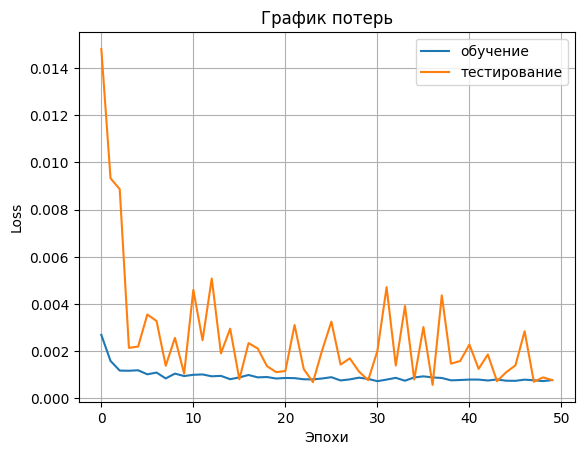

In [35]:
plt.plot(history.history['loss'], label='обучение')
plt.plot(history.history['val_loss'], label='тестирование')
plt.title('График потерь')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

По графику видно, что функция потерь на тестовых данных значительно низкая, поэтому следующим шагом производится тестирование и анализ работы модели.

---

### Тестирование и анализ

Для того, чтобы проверить обученную модель, делаются предсказания на тестовых данных. Так как предсказания приходят в нормализованном виде, нужно сразу их обратно конвертировать в привычные.

In [36]:
predictions = model.predict(X_test)
predictions_rescaled = scaler2.inverse_transform(predictions)
y_test_rescaled = scaler2.inverse_transform(y_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


После этого подсчитываются метрики качества модели.

In [37]:
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

Для сравнения данные восстанавливаются с помощью линейной интерполяции для сравнения с моделью. Сразу подсчитываются метрики качества

In [60]:
linear_predictions = test_df.Close_noisy.interpolate(method='linear').iloc[window:].values
linear_mse = mean_squared_error(clean_target.tail(len(linear_predictions)), linear_predictions)
linear_mae = mean_absolute_error(clean_target.tail(len(linear_predictions)), linear_predictions)
linear_r2 = r2_score(clean_target.tail(len(linear_predictions)), linear_predictions)

In [61]:
metrics = pd.DataFrame({
    'metrics' : ['MSE', 'MAE', 'R^2'],
    'RNN LSTM' : [mse, mae, r2],
    'Линейная интерполяция' : [linear_mse, linear_mae, linear_r2]
})
metrics.set_index('metrics', inplace=True)
metrics.round(3)

,RNN LSTM,Линейная интерполяция
metrics,,
MSE,3498301.026,1256321.001
MAE,1272.671,884.101
R^2,0.995,0.998


Метрики двух методов интерполяции временных рядов не сильно отличаются, если учитывать, что MSE (средняя квадратическая ошибка) показывает квадрат ошибки. Из-за этого такие большие расхождения. Но, тем не менее, на основе метрик можно сделать вывод, что линейная интерполяция справляется с задачей лучше. 

Для более полного анализа и сравнения методов строится график и истинным временным рядом, предсказанным и восстановленным с помощью линейной интерполялции.

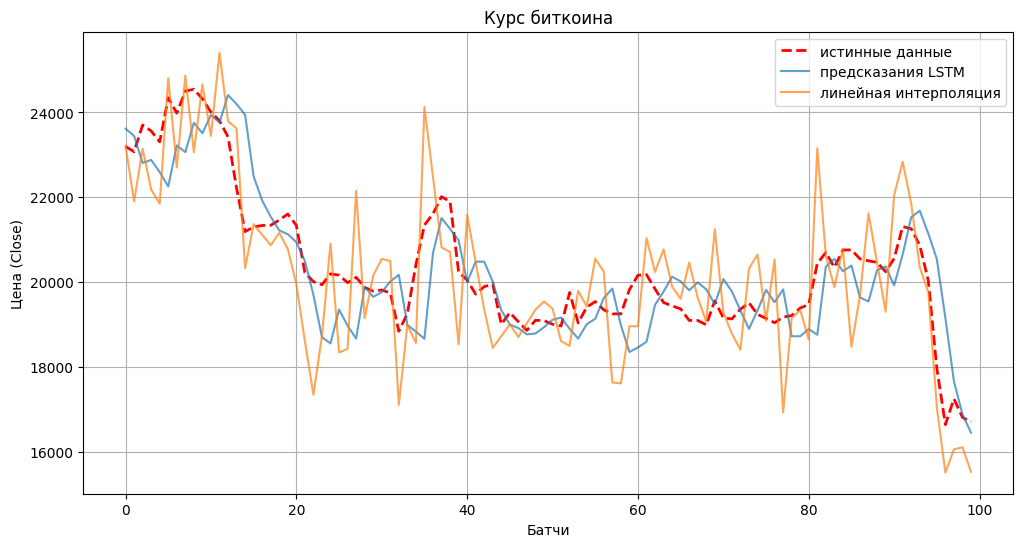

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:100], label='истинные данные', color='red', linewidth=2, linestyle='--')
plt.plot(predictions_rescaled[:100], label='предсказания LSTM', alpha=0.7)
plt.plot(linear_predictions[:100], label='линейная интерполяция', alpha=0.7)
plt.title('Курс биткоина')
plt.xlabel('Батчи')
plt.ylabel('Цена (Close)')
plt.legend()
plt.grid(True)
plt.show()

По графику отчетливо видно, что RNN LSTM значительно лучше справляется с интерполяцией временного ряда, так как ее значения лучше описывают исходные данные, в то время как линейная интерполяция показывает более рывкообразные и менее полезные для применения результаты.

Последним шагом результаты проделанной работы, а именно - параметры обученной модели, сохраняются для возможного дальнейшего использования.

In [64]:
# model.save('lstm.keras')

---

### Выводы

В ходе выполнения работы было изучено, как рекуррентные нейронные сети (RNN), а именно LSTM, могут использоваться для интерполяции временных рядов на примере данных о ценах на биткоин. В ходе выполнения работы было проведено сравнение эффективности данных моделей по сравнению с классическими методами, такими как линейная интерполяция.

В процессе выполнения работы были выполнены этапы подготовки данных, обучения модели, подгонки параметров, интерполяции временного ряда, а также анализа и сравнения с методом линейной интерполяции. 

Несмотря на то что метрики качества показали некоторые расхождения, визуальный анализ дал понять, что LSTM более эффективно восстанавливает пропущенные значения, в то время как линейная интерполяция выдает менее качественные результаты.

Подводя итог, можно сказать, что использование рекурентный нейронных сетей, а именно - LSTM, является хорошим подходом для решения задач интерполяции данных. 